In [1]:
import torch
import pennylane as qml
from itertools import combinations
from time_series_utils import generate_synthetic_correlated_time_series, apply_sax, classical_transition_matrix, flatten_recursive
import matplotlib.pyplot as plt
import numpy as np

from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.piecewise import SymbolicAggregateApproximation

series_dim = 2
n_subspace_qubits = 3
environment_qubits = n_subspace_qubits
n_qubits = series_dim*n_subspace_qubits + environment_qubits
dev = qml.device("default.qubit", wires= n_qubits)
W = qml.StronglyEntanglingLayers
W_layers = 2
h = 2

[1, 21, 41, 61, 81]
{1: [[7, 7, 6, 6, 6, 7, 6, 5, 4, 5, 2, 2, 2, 1, 1, 0, 0, 0, 1, 1], [6, 4, 7, 7, 7, 1, 3, 1, 3, 0, 3, 1, 4, 3, 1, 4, 3, 4, 2, 1]], 21: [[7, 7, 7, 6, 6, 7, 4, 4, 4, 3, 1, 1, 0, 1, 3, 0, 1, 1, 2, 1], [5, 7, 7, 4, 3, 0, 4, 1, 4, 3, 3, 4, 7, 6, 1, 3, 1, 1, 0, 3]], 41: [[7, 7, 7, 7, 6, 5, 4, 1, 0, 1, 1, 1, 2, 2, 2, 3, 2, 1, 3, 2], [0, 0, 0, 0, 4, 4, 3, 7, 7, 6, 6, 6, 4, 2, 3, 3, 6, 5, 2, 1]], 61: [[6, 6, 7, 7, 7, 6, 6, 5, 4, 4, 2, 2, 1, 2, 2, 1, 1, 1, 0, 0], [0, 1, 0, 0, 0, 3, 3, 6, 3, 5, 5, 2, 7, 6, 6, 3, 3, 4, 7, 7]], 81: [[7, 7, 7, 7, 6, 6, 6, 3, 2, 2, 4, 3, 1, 0, 1, 2, 0, 1, 2, 3], [6, 6, 6, 2, 2, 3, 2, 2, 5, 4, 4, 3, 6, 7, 6, 2, 4, 2, 0, 0]]}


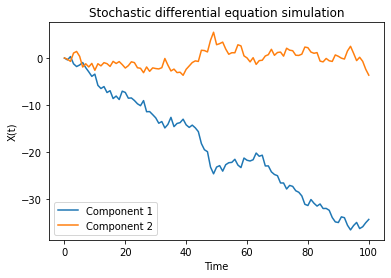

1


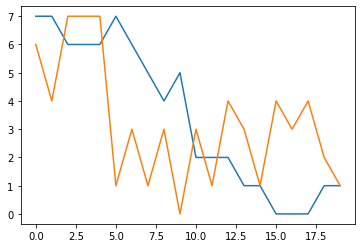

21


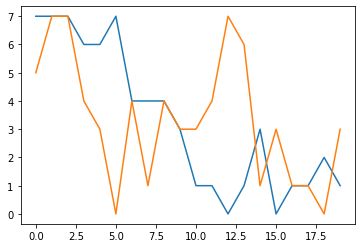

41


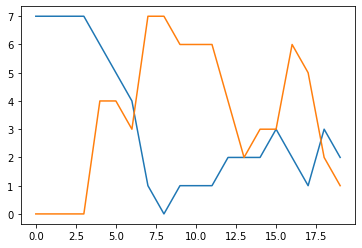

61


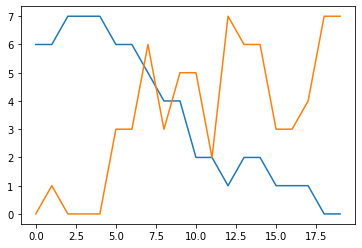

81


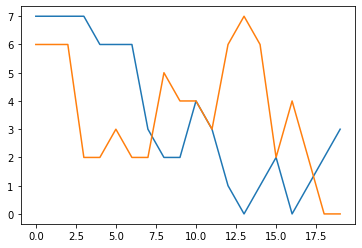

In [2]:

T = 100
N = 100
X = generate_synthetic_correlated_time_series(T, N)
#print("shape", X.shape)
X_d = {}
X_discrete_d = {}
classical_transition_matrices = {}
n_segments = 20
window = 20
time_steps = []

scalers = {}
saxs = {}

for i in range(1, N + 1, window):
    time_steps.append(i)
    X_d[i] = [x[i:i+window] for x in X]
    scaler = TimeSeriesScalerMeanVariance(mu=0, std=1)  # How should we rescale the data?
    sax = SymbolicAggregateApproximation(n_segments=n_segments, alphabet_size_avg=2**n_subspace_qubits)
    discrete_X, time_series_sax = apply_sax(scaler, sax, X_d[i], n_segments, n_sax_symbols = 2**n_subspace_qubits)
    scalers[i] = scaler
    saxs[i] = sax
    X_discrete_d[i] = ([list(flatten_recursive(x)) for x in time_series_sax])
    classical_matrix = torch.Tensor(classical_transition_matrix(list(flatten_recursive(time_series_sax))))
    classical_transition_matrices[i] = (classical_matrix)

print(time_steps)
print(X_discrete_d)
import copy
X_discrete_d_2 = copy.deepcopy(X_discrete_d)

time = np.linspace(0, T, N + 1)
for i in range(2):
    plt.plot(time, X[i], label=f'Component {i+1}')
plt.xlabel('Time')
plt.ylabel('X(t)')
plt.title('Stochastic differential equation simulation')
plt.legend()
plt.show()

# Visualize the data in X_discrete_d_2
for i in range(1, N + 1, window):
    print(i)
    for j in range(series_dim):
        plt.plot(X_discrete_d_2[i][j])
    plt.show()
    
# Plot the original data in X
#for i in range(1, N + 1, window):
#    for j in range(series_dim):
#        plt.plot(X_d[i][j])
#    plt.show()


In [3]:
# This is the diagonal which is located between start and stop
def D(gamma: torch.Tensor, start : int, stop : int, h: int = None, get_probs: bool = False) -> None:
    """https://doi.org/10.1088/1367-2630/16/3/033040"""
    #print(gamma)
    if h is None:
        h = stop - start
    cnt = 0
    for i in range(1, h + 1):
        for comb in combinations(range(start, stop), i):
            if len(comb) == 1:
                qml.RZ(gamma[cnt], wires=[comb[0]])
                cnt += 1
            elif len(comb) > 1:
                cnots = [comb[i : i + 2] for i in range(len(comb) - 1)]
                for j in cnots:
                    qml.CNOT(wires=j)
                qml.RZ(gamma[cnt], wires=[comb[-1]])
                cnt += 1
                for j in cnots[::-1]:
                    qml.CNOT(wires=j)
    if get_probs:
        return qml.probs(wires=range(start, stop))

In [4]:
def D2(gamma: torch.Tensor, n_qubits: int, k: int = None, get_probs: bool = False) -> None:
    if k is None:
        k = n_qubits
    cnt = 0
    for i in range(1, k + 1):
        for comb in combinations(range(n_qubits), i):
            if len(comb) == 1:
                qml.RZ(gamma[cnt], wires=[comb[0]])
                cnt += 1
            elif len(comb) > 1:
                cnots = [comb[i : i + 2] for i in range(len(comb) - 1)]
                for j in cnots:
                    qml.CNOT(wires=j)
                qml.RZ(gamma[cnt], wires=[comb[-1]])
                cnt += 1
                for j in cnots[::-1]:
                    qml.CNOT(wires=j)
    if get_probs:
        return qml.probs(wires=range(n_qubits))

In [5]:
# Now X = (s_1, ..., s_m) where each s_i is a discrete time series
# Depending on the discretization, we use x subspace qubits to encode space H_s_i
@qml.qnode(dev, interface="torch", diff_method="backprop")
def circuit(
    X: torch.Tensor,
    time_step: float,
    n_subspace_qubits: int,
    environment_qubits: int,
    projected_subspace,
    alpha: torch.Tensor,
    gamma: torch.Tensor,
    h: int,
    W: callable,
    D: callable,
    n_qubits: int,
    measurement: str
) -> torch.Tensor:
    
    for i, point in enumerate(X):
        subspace = range(i*n_subspace_qubits, (i + 1)*n_subspace_qubits) 
        qml.BasisEmbedding(int(point), wires=subspace)
    
    W(alpha, wires=range(n_qubits))
    D2(gamma * time_step, n_qubits, h)
    qml.adjoint(W)(alpha, wires=range(n_qubits))
    
    return qml.probs(wires = projected_subspace)

In [6]:
def get_initial_parameters(W, W_layers, n_subspace_qubits, seed = 0):
    torch.manual_seed(seed)
    init_alpha = torch.rand(W.shape(W_layers, n_qubits))
    init_gamma = torch.rand(5*(n_qubits + 1))
    init_params = {
        "alpha": (2 * torch.pi * init_alpha).clone().detach().requires_grad_(True),
        "gamma": (2 * torch.pi * init_gamma).clone().detach().requires_grad_(True),
    }
    return init_params

In [7]:
kl_loss = torch.nn.KLDivLoss(reduction="batchmean")
import torch.nn.functional as F

def loss_function(time_step, X, alpha, gamma, classical_transition_matrices):
    loss = torch.tensor(0.0, requires_grad=True)
    for segment in zip(*X):
        for j in range(series_dim):
            subspace = range(n_subspace_qubits*j, n_subspace_qubits*(j + 1))
            probs = circuit(segment, time_step, n_subspace_qubits, environment_qubits, subspace, alpha, gamma, h, W, D, n_qubits, measurement = "probs")
            loss_now = kl_loss(F.log_softmax(probs, dim=0), 
                               classical_transition_matrices[time_step][segment[j]])
            loss = loss + loss_now
    return loss

In [8]:
def train_model(
    lr: float,
    init_params: dict,
    pytorch_optimizer: callable,
    cycler,
    batch_iterations: int,
    classical_transition_matrices,
    seed=0,
    print_intermediate=True,
    time_steps = time_steps
) -> dict:
    torch.manual_seed(seed)
    opt = pytorch_optimizer(init_params.values(), lr=lr)
    alpha = init_params["alpha"]
    gamma = init_params["gamma"]

    def closure():
        opt.zero_grad()
        loss = torch.tensor(0.0, requires_grad=True)
        for i, data in enumerate(cycler):
            loss = loss_function(time_steps[i], data, alpha, gamma, classical_transition_matrices)
            loss.backward()
        return loss

    loss_history = []
    for i in range(batch_iterations):
        loss = opt.step(closure)
        loss_history.append(loss.item())
        if batch_iterations % 10 == 0 and print_intermediate:
            print(f"Iteration number {i}, Current loss {loss.item()}")

    results_dict = {
        "opt_params": {
            "alpha": opt.param_groups[0]["params"][0],
            "gamma": opt.param_groups[0]["params"][1]
        },
        "loss_history": loss_history,
    }
    return results_dict

In [9]:
init_params = get_initial_parameters(W, W_layers, n_subspace_qubits)
cycler = torch.utils.data.DataLoader(list(X_discrete_d.values()), batch_size=1, shuffle=False)
lr = 0.01
pytorch_optimizer = torch.optim.Adam
batch_iterations = 50
result = train_model(lr, init_params, pytorch_optimizer, cycler, batch_iterations, classical_transition_matrices)
print(result)

Iteration number 0, Current loss 5.019174790260555
Iteration number 1, Current loss 5.007549472733913
Iteration number 2, Current loss 5.0280200359126255
Iteration number 3, Current loss 5.005670228104302
Iteration number 4, Current loss 4.983939653855705
Iteration number 5, Current loss 4.94600885087808
Iteration number 6, Current loss 4.937411453622842
Iteration number 7, Current loss 4.932187355189829
Iteration number 8, Current loss 4.9287980106471645
Iteration number 9, Current loss 4.944492016345318
Iteration number 10, Current loss 4.93719192592896
Iteration number 11, Current loss 4.939585018530136
Iteration number 12, Current loss 4.913797335967944
Iteration number 13, Current loss 4.915618284769019
Iteration number 14, Current loss 4.903223485981365
Iteration number 15, Current loss 4.898596418574911
Iteration number 16, Current loss 4.909674235047246
Iteration number 17, Current loss 4.912196542106787
Iteration number 18, Current loss 4.900628258188803
Iteration number 19, C

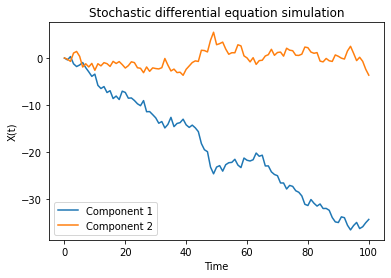

In [10]:
time = np.linspace(0, T, N + 1)
for i in range(2):
    plt.plot(time, X[i], label=f'Component {i+1}')
plt.xlabel('Time')
plt.ylabel('X(t)')
plt.title('Stochastic differential equation simulation')
plt.legend()
plt.show()

In [11]:
# Now X = (s_1, ..., s_m) where each s_i is a discrete time series
# Depending on the discretization, we use x subspace qubits to encode space H_s_i
sampler = qml.device("default.qubit", wires= n_qubits, shots=1)
@qml.qnode(sampler, interface="torch")
def single_sample_circuit(
    X: torch.Tensor,
    time_step: float,
    n_subspace_qubits: int,
    environment_qubits: int,
    projected_subspace,
    alpha: torch.Tensor,
    gamma: torch.Tensor,
    h: int,
    W: callable,
    D: callable,
    n_qubits: int,
    measurement: str
) -> torch.Tensor:
    for i, point in enumerate(X):
        subspace = range(i*n_subspace_qubits, (i + 1)*n_subspace_qubits) 
        qml.BasisEmbedding(point, wires=subspace)
    
    W(alpha, wires=range(n_qubits))
    D2(gamma * time_step, n_qubits, h)
    qml.adjoint(W)(alpha, wires=range(n_qubits))
    
    # We take a single sample from the circuit for evaluation
    return qml.sample(wires = projected_subspace)

In [14]:
def generate_time_series_from_quantum_model(alpha, gamma, time_steps, n_subspace_qubits, environment_qubits, h, W, D, n_qubits, measurement = "probs"):
    full_result = []
    for t in time_steps:
        result = [[], []]
        state = [[0]*n_subspace_qubits]*2
        for segment in range(n_segments):
            for j in range(series_dim):
                subspace = range(n_subspace_qubits*j, n_subspace_qubits*(j + 1))
                prob = single_sample_circuit(state, t, n_subspace_qubits, environment_qubits, subspace, alpha, gamma, h, W, D, n_qubits, measurement = "probs")
                #print("Prob: ", prob)
                most_probable_state = ''.join(str(int(e)) for e in prob)
                # visualize the circuit
                #fig, plt = qml.draw_mpl(circuit)(state, t, n_subspace_qubits, environment_qubits, subspace, alpha, gamma, h, W, D, n_qubits, measurement = "probs")
                #fig.savefig(f"quantum_circuit_{t}_{j}.png")
                result[j].append(int(most_probable_state, 2))
            state = [int(x[-1]) for x in result]
            #print("State: ", state)
        full_result.append(result)
    return full_result
    

In [15]:
generated_time_series = generate_time_series_from_quantum_model(
    result["opt_params"]["alpha"], 
    result["opt_params"]["gamma"], 
    time_steps, 
    n_subspace_qubits, 
    environment_qubits, 
    h, 
    W, 
    D, 
    n_qubits)
print("Generated: ", generated_time_series)
print("Original: ", X_discrete_d)

for i in range(1, N + 1, window):
    print(i)
    for j in range(series_dim):
        plt.plot(generated_time_series[i][j])
    plt.show()

IndexError: list index out of range

In [ ]:
generated_time_series_full = [[], []]
for segment in generated_time_series:
    for elem in zip(*segment):
        for i in range(len(elem)):
            generated_time_series_full[i].append(elem[i])

print("Generated full: ", generated_time_series_full)

discrete_X_full = [[], []]

for segment in X_discrete_d_2:
    for elem in zip(*segment):
        for i in range(len(elem)):
            discrete_X_full[i].append(elem[i])
            
print("Original full: ", discrete_X_full)

# Visualize the results
time = np.linspace(0, T, len(discrete_X_full[0]))
#for i in range(2):
#    plt.plot(time, discrete_X_full[i], label=f'Component {i+1}')
for i in range(2):
    plt.plot(time, generated_time_series_full[i], label=f'Generated component {i+1}')
plt.xlabel('Time')
plt.ylabel('X(t)')
plt.title('Stochastic differential equation simulation')
plt.legend()
plt.show()

c:\Users\valte\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:90: UserWarning: 2-Dimensional data passed. Assuming these are 2 1-dimensional timeseries
  warnings.warn(
c:\Users\valte\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:90: UserWarning: 2-Dimensional data passed. Assuming these are 2 1-dimensional timeseries
  warnings.warn(


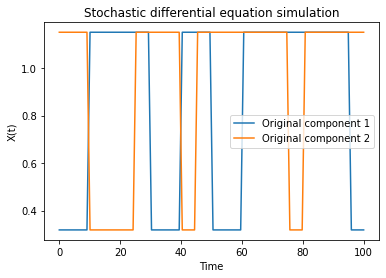

In [ ]:
inverse_sax_original = apply_sax(scaler, sax, discrete_X_full, n_segments, n_sax_symbols = 2**n_subspace_qubits, inverse = True)
inverse_sax_generated = apply_sax(scaler, sax, generated_time_series_full, n_segments, n_sax_symbols = 2**n_subspace_qubits, inverse = True)

# Visualize the results
time = np.linspace(0, T, len(inverse_sax_original[0]))
for i in range(2):
    plt.plot(time, inverse_sax_original[i], label=f'Original component {i+1}')
#for i in range(2):
#    plt.plot(time, inverse_sax_generated[i], label=f'Generated component {i+1}')
plt.xlabel('Time')
plt.ylabel('X(t)')
plt.title('Stochastic differential equation simulation')
plt.legend()
plt.show()